In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
#import os
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
from google.colab import files
drive.mount('/content/drive')
heart_csv_path = 'drive/MyDrive/Colab Notebooks/diabetes.csv'

Mounted at /content/drive


In [3]:
data = pd.read_csv(heart_csv_path)

In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
X = data.loc[:,data.columns!='Outcome']
y = data.iloc[:,-1]

In [6]:
feature_columns = []

#for header in ['Age', 'Insulin', 'BMI', 'BloodPressure', 'Glucose', 'SkinThickness']:
  #feature_columns.append(tf.feature_column.numeric_column(header))
NUMERIC_COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# bucketized cols
age = tf.feature_column.numeric_column("Age")
#og, run 1: loss: 0.6079 - accuracy: 0.6810, run 2: loss: 0.5939 - accuracy: 0.7672, run 3: loss: 0.6903 - accuracy: 0.7241
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

#change 1: [18, 25, 30, 35, 45, 50, 55, 60, 65], run 1 acc: 0.7500, run 2 acc: 0.7500, run 3 acc: 0.6983
#age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 45, 50, 55, 60, 65])

#change 2:[24, 29, 41], run 1: loss: 0.5973 - accuracy: 0.7069, run 2: loss: 0.5931 - accuracy: 0.6724, run 3:loss: 0.6250 - accuracy: 0.6983
#age_buckets = tf.feature_column.bucketized_column(age, boundaries=[24, 29, 41])

#change 3:[22, 24, 26, 35, 41, 61], run 1: loss: 0.5673 - accuracy: 0.7241, run 2: loss: 0.6103 - accuracy: 0.7328, run 3: loss: 0.6540 - accuracy: 0.6983
#age_buckets = tf.feature_column.bucketized_column(age, boundaries=[22, 24, 26, 35, 41, 61])

#change 4:[18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 75, 77, 80], run 1: loss: 0.6094 - accuracy: 0.7241, run 2:loss: 0.6176 - accuracy: 0.7328, run 3: loss: 0.6534 - accuracy: 0.7155
#age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 75, 77, 80])

feature_columns.append(age_buckets)


# feature_columns.append(cp_slope_crossed)
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Outcome')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

train, test = train_test_split(data, test_size=0.15, random_state=RANDOM_SEED)


train_ds = create_dataset(train)
test_ds = create_dataset(test)

model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')

])

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=500, use_multiprocessing=False, verbose = 0)
model.evaluate(test_ds)

4/4 [==============================] - 0s 4ms/step - loss: 1.8322 - accuracy: 0.6552


[1.8322021961212158, 0.6551724076271057]

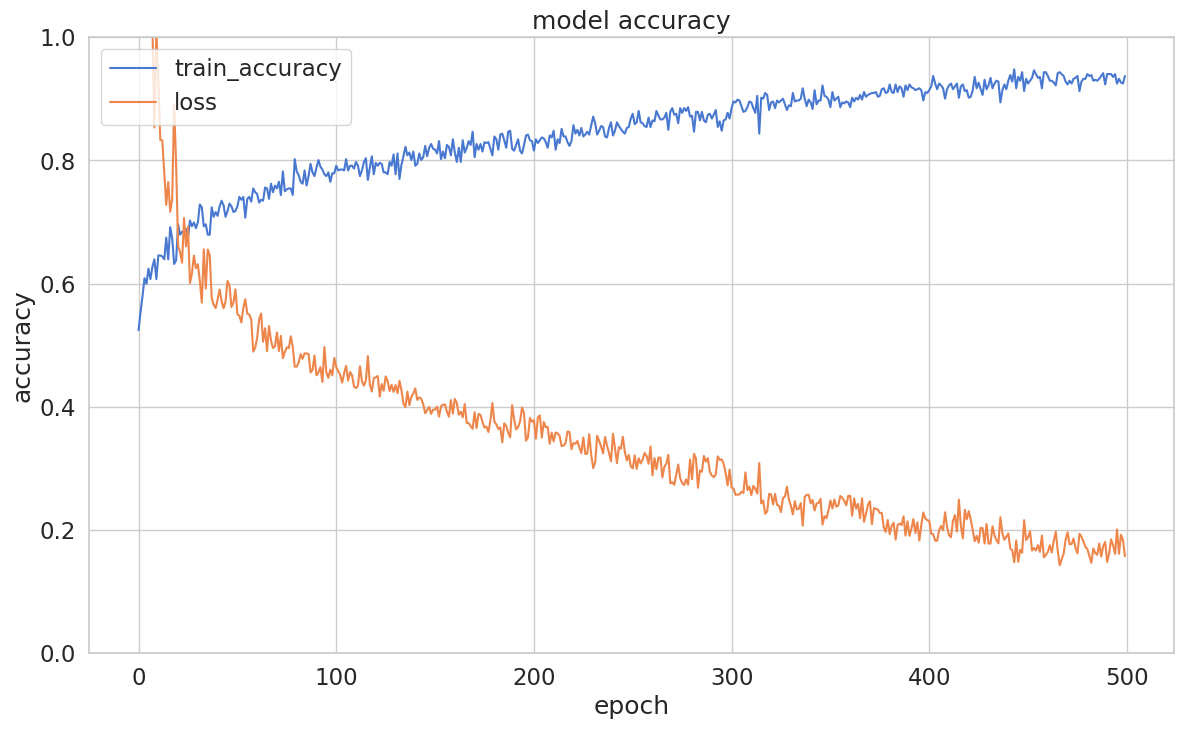

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train_accuracy', 'loss'], loc='upper left');

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix